# Imports and data

In [14]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import seaborn as sns
import utils.base_utils as bu
import utils.window_utils as wu
import numpy as np
from utils.macro_grouping import add_group_level, build_full_group_mapping, groups_as_array

# Bianchi period:
start_date = '1971-08-31'
end_date = '2018-12-31'


# end_date = '2025-06-30' # kr and gsw end date
maturities = [str(i) for i in range(12, 121) if i % 12 == 0] # select only yearly maturities

yields = bu.get_yields(type='lw', start=start_date, end=end_date, maturities=maturities) # type can be kr, lw, gsw
forward = bu.get_forward_rates(yields)
xr = bu.get_excess_returns(yields, horizon=12).dropna() # horizon=12 means holding for 12 months
fred_md_raw = bu.get_fred_data('data/2026-01-MD.csv', start=start_date, end=end_date) # this is aligned to the last day of the previous month, so we get the same number of observations as the yields data

monthly_yields = bu.get_yields(type='lw', start=start_date, end=end_date, maturities=[str(i) for i in range(1, 121)]) # needed for monthly holding period excess returns. Not available for gsw
monthly_xr = bu.get_excess_returns(monthly_yields, horizon=1).dropna() # calculate monthly excess returns for robustness

# At time t (end of month), we only know data for month t-1
fred_md = fred_md_raw.shift(1)  

# Drop dates outside the xr range
yields = yields.loc[yields.index <= xr.index[-1]]
forward = forward.loc[forward.index <= xr.index[-1]]
xr = xr.loc[xr.index <= xr.index[-1]]
fred_md = fred_md.loc[fred_md.index <= xr.index[-1]]
monthly_xr = monthly_xr.loc[monthly_xr.index <= xr.index[-1]]

# Backfill fred_md to avoid nans
fred_md = fred_md.bfill()

# Construct X with 3-level MultiIndex: (source, group, series)
s2g = build_full_group_mapping(fred_md, forward, yields)

X = pd.concat([fred_md, forward, yields],
               axis=1,
               keys=['fred', 'forward', 'yields'])

X = add_group_level(X, s2g, level_name='group')
X = X.sort_index(axis=1, level='group')
groups = groups_as_array(X, level='group')

y_all = xr[['24','36','48','60','72','84','96','108','120']].values
dates = xr.index

# Expanding window estimation

In [2]:
from models.base import *
from models.classical import *
from models.other import *
from models.ann import *
from models.gbt import *
from models.linear import *
from models.tree import *

y = monthly_xr['120'].values # 1-month excess returns
# y = xr['120'].values # 10-year overlapping excess returns
OOS_start = pd.Timestamp('1990-01-31')
# OOS_start = pd.Timestamp('1972-01-31')

seeds = [1]
coefs = []

def record_coef(coef):
    coefs.append(np.abs(coef).copy())  # store absolute value

for seed in seeds:
    print(f"Running seed {seed}...")
    # Models to test
    models = {
        # 'Lasso': LassoModel(series='forward'),
        # 'Ridge': RidgeModel(series='forward'),
        # 'ExtraTrees': ExtraTreesModel(features={
        #     'forward': {'method': 'raw'},
        # }),
        # 'Linear': LinearModel(),
        'PCA': PCABaselineModel(components=3, series='forward'),
        # 'PCAPlusN': PCABaselineModelPlusN(components=3, series='forward', n_extra=3),
        # 'PCAMacroGroups': PCABaselineModelMacroGroups(components=3, series='forward', lasso=True, alpha=0.01),
        # 'PCAMacroGroupsNoLasso': PCABaselineModelMacroGroups(components=3, series='forward', lasso=False, alpha=0.01),
        # 'GroupPCARF': GroupPCARandomForest(components=3, series='forward', macro_pcs=1),
        # 'GroupLasso': GroupLassoModel(alpha=0.01, groups=groups),
        # 'RW': RandomWalkModel(),
        # 'Mean': HistoricalMeanModel(),
        # 'CP': CochranePiazzesiModel(),
        # 'LN': LudvigsonNgModel(),
        # 'LN_BH': LudvigsonNgBauerHamiltonSpec(),
        # 'BianchiENet': BianchiElasticNet()
    }

    results = {}

    for name, model in models.items():
        print(f"Running {name}...")
        y_forecast_bianchi = wu.expanding_window(
            model, X, y, dates, OOS_start, 
            gap=0,         # gap = 11 for annual yields
            val_len=None,    # Trigger Bianchi internal split
            refit_freq=1,     # Refit every month
            coef_callback=record_coef # Only implemented for linear models (ols, pcr, lasso, ridge, elasticnet). Comment out if not applicable.
        )

        # y_forecast_gkx = wu.expanding_window( # GKX is included as a robustness check, but not the main focus of the paper, so we use the same refit_freq and val_len as Bianchi for simplicity. Currently only implemented for Lasso
        #     model, X, y, dates, OOS_start, 
        #     gap=0,         # Safety for annual returns
        #     val_len=144,     # 12 years of validation
        #     refit_freq=12    # Annual refit
        #     coef_callback=None
        # )

        # Report both in your results table
        for bench_name, bench in [('zero (EH)', 'zero'), ('hist_mean (C-T)', 'hist_mean')]:
            r2 = wu.oos_r2(y, y_forecast_bianchi, benchmark=bench)
            print(f"  B: R2_OOS [{bench_name}] = {r2:.4f}")        

        # for bench_name, bench in [('zero (EH)', 'zero'), ('hist_mean (C-T)', 'hist_mean')]:
        #     r2 = wu.oos_r2(y, y_forecast_gkx, benchmark=bench)
        #     print(f"  GKX: R2_OOS [{bench_name}] = {r2:.4f}")

Running seed 1...
Running PCA...


100%|██████████| 336/336 [00:02<00:00, 164.94it/s]

  B: R2_OOS [zero (EH)] = 0.0229
  B: R2_OOS [hist_mean (C-T)] = 0.0094


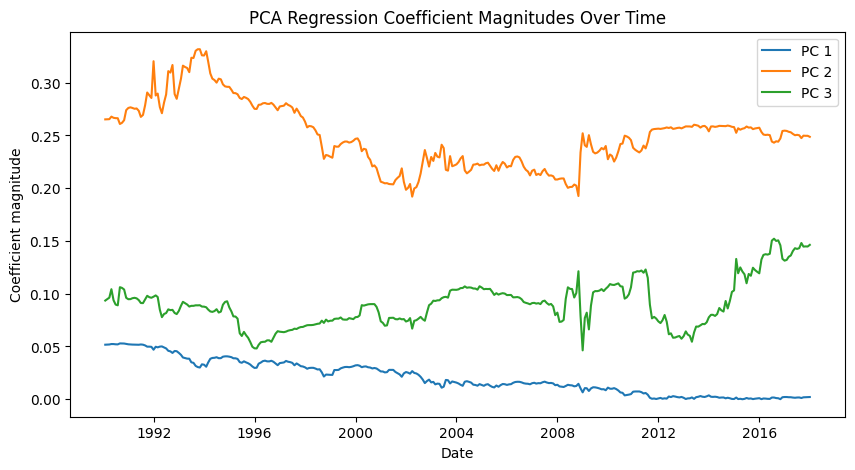

In [3]:
import matplotlib.pyplot as plt
import numpy as np

coefs_arr = np.stack(coefs)  # shape: (n_steps, n_features)
oos_dates = dates[dates >= OOS_start]  # or whatever your OOS date logic is

plt.figure(figsize=(10, 5))
for i in range(coefs_arr.shape[-1]):
    plt.plot(oos_dates, coefs_arr[:, i], label=f'PC {i+1}')
plt.xlabel('Date')
plt.ylabel('Coefficient magnitude')
plt.title('PCA Regression Coefficient Magnitudes Over Time')
plt.legend()
plt.show()

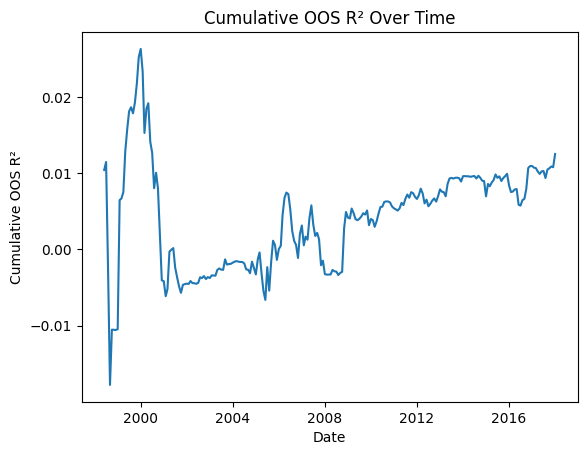

In [4]:
dynamic_r2 = []
oos_indices = np.where(dates >= OOS_start)[0]
for t in range(1, len(oos_dates)+1):
    # y_true and y_pred up to current OOS step
    y_true_cum = y[oos_indices[:t]]
    y_pred_cum = y_forecast_bianchi[oos_indices[:t]]
    r2_cum = wu.oos_r2(y_true_cum, y_pred_cum, benchmark='hist_mean')
    dynamic_r2.append(r2_cum)

plt.plot(oos_dates[100:], dynamic_r2[100:])
plt.xlabel('Date')
plt.ylabel('Cumulative OOS R²')
plt.title('Cumulative OOS R² Over Time')
plt.show()

<Axes: xlabel='date'>

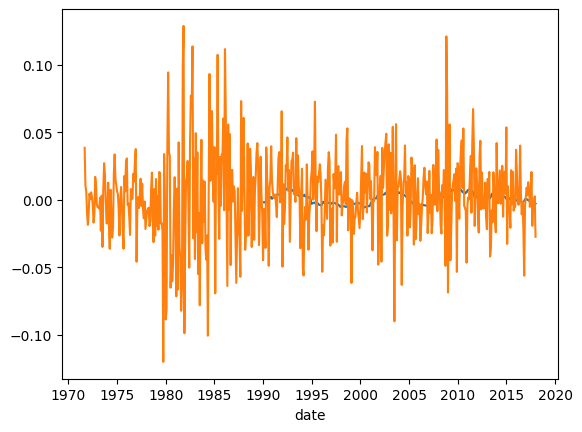

In [5]:
sns.lineplot(y=y_forecast_bianchi, x=yields.index)
sns.lineplot(y=y, x=yields.index)

# Neural networks with multiple outputs:

In [13]:
import torch
import numpy as np
from models.ann import (
    ForwardRateNet, MacroFwdHybridNet, GroupEnsembleNet,
    ForwardRateANN, HybridANN, GroupEnsembleANN
)

def validate_any_structure(model_obj, n_fwd=10, n_out=6, n_macro=126):
    """
    Validates Forward, Hybrid, or Group-Ensemble structures.
    Handles both the raw PyTorch Modules and the ANN Wrapper classes.
    """
    print(f"\n{'='*20} Validating: {model_obj.__class__.__name__} {'='*20}")

    # 1. Identify if we are dealing with a Wrapper or a raw Module
    if hasattr(model_obj, '_build_model'): # It's a Wrapper (ANN class)
        print("Detected: Wrapper Class. Extracting internal model...")
        
        if isinstance(model_obj, ForwardRateANN):
            pt_model = model_obj._build_model(n_fwd, n_out, dropout=0.0)
            dummy_inputs = [torch.randn(1, n_fwd)]
            
        elif isinstance(model_obj, HybridANN):
            pt_model = model_obj._build_model(n_macro, n_fwd, n_out, dropout=0.0)
            dummy_inputs = [torch.randn(1, n_macro), torch.randn(1, n_fwd)]
            
        elif isinstance(model_obj, GroupEnsembleANN):
            # Mock 8 macro groups for FRED (common in Bianchi/Fan papers)
            # 126 variables split into 8 groups
            mock_group_sizes = [23, 16, 16, 16, 16, 16, 15, 15] 
            pt_model = model_obj._build_model(mock_group_sizes + [n_fwd], n_out, dropout=0.0)
            dummy_inputs = [torch.randn(1, s) for s in mock_group_sizes] + [torch.randn(1, n_fwd)]
    else:
        # It's a raw PyTorch Module
        pt_model = model_obj
        # We assume n_macro/n_fwd logic for raw modules
        if isinstance(pt_model, ForwardRateNet):
            dummy_inputs = [torch.randn(1, n_fwd)]
        elif isinstance(pt_model, MacroFwdHybridNet):
            dummy_inputs = [torch.randn(1, n_macro), torch.randn(1, n_fwd)]
        elif isinstance(pt_model, GroupEnsembleNet):
            # Logic for raw GroupEnsembleNet depends on how it was initialized
            print("Direct validation of GroupEnsembleNet requires manual input list.")
            return

    # 2. Print Architecture
    print("\n--- PyTorch Architecture ---")
    print(pt_model)
    
    # 3. Perform Forward Pass
    pt_model.eval()
    with torch.no_grad():
        # Unpack inputs list into the model
        out = pt_model(*dummy_inputs)
    
    print(f"\nInput Tensors: {len(dummy_inputs)}")
    print(f"Output Shape:  {out.shape} (Expected: [1, {n_out}])")
    
    assert out.shape == (1, n_out), f"Dimension mismatch! Got {out.shape}"
    print("\nRESULT: Validation Successful.")

# --- RUNNING THE VALIDATION ---

# 1. Test Forward Rate (Simple)
model_fwd = ForwardRateANN(archi=(3,))
validate_any_structure(model_fwd)

# 2. Test Hybrid (Diagram b)
model_hyb = HybridANN(archi_macro=(32, 16), archi_fwd=(3,))
validate_any_structure(model_hyb)

# 3. Test Group Ensemble (Diagram c)
model_grp = GroupEnsembleANN(archi_group=(1,), archi_fwd=(3,))
validate_any_structure(model_grp)


==================== Validating: ForwardRateANN ====================
Detected: Wrapper Class. Extracting internal model...

--- PyTorch Architecture ---
ForwardRateNet(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=3, out_features=6, bias=True)
  )
)

Input Tensors: 1
Output Shape:  torch.Size([1, 6]) (Expected: [1, 6])

RESULT: Validation Successful.

==================== Validating: HybridANN ====================
Detected: Wrapper Class. Extracting internal model...

--- PyTorch Architecture ---
MacroFwdHybridNet(
  (macro_tower): Sequential(
    (0): Linear(in_features=126, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (fwd_tower): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
  )
  (output_layer): Linear(in

In [ ]:
from models.ann import ForwardRateANN, HybridANN, GroupEnsembleANN

OOS_start = pd.Timestamp('1990-01-31')
# OOS_start = pd.Timestamp('2016-01-31')

# y = xr['120'].values # 10-year excess returns
y_all = xr[['24','36','48','60','72','84','96','108','120']].values

# y = monthly_xr['120'].values # 1-month excess returns for robustness
# y_all = monthly_xr[['24','36','48','60','72','84','96','108','120']].values

dates = monthly_xr.index

models = {
    # Forward rates only (simple)
    # 'FwdANN_1_3': ForwardRateANN(archi=(8, 4), series='forward', 
    #                           do_grid_search=True, tune_every=60, seed=42,
    #                           param_grid = {'Dropout': [0.0, 0.1], 'l1l2': [1e-4]},
    #                           epochs=100, patience=10),
    
    # 'HybridANN': HybridANN(archi_macro=(32, 16, 8), archi_fwd=(3,), 
    #                        param_grid = {'Dropout': [0.0, 0.1], 'l1l2': [1e-4]},
    #                        do_grid_search=True, tune_every=60,
    #                        epochs=100, patience=10, seed=42),
    
    'GroupEnsembleANN': GroupEnsembleANN(archi_group=(1,), archi_fwd=(3,), 
                        param_grid = {'Dropout': [0.1, 0.3, 0.5], 'l1l2': [1e-4]},
                        do_grid_search=True, tune_every=60,
                        epochs=100, patience=10, seed=42),
}

# All use the same API:
for name, model in models.items():
    y_forecast = wu.expanding_window(model, X, y_all, dates, OOS_start, gap=0, refit_freq=1)
    r2s = wu.oos_r2(y_all, y_forecast, benchmark='hist_mean')
    print("\n--- OOS R² Summary ---")
    for mat, r2 in zip(['24','36','48','60','72','84','96','108','120'], r2s):
        print(f"  {mat}m: {r2:.4f}")

  0%|          | 0/24 [00:00<?, ?it/s]

Grid search triggered for GroupEnsembleANN...


100%|██████████| 24/24 [02:21<00:00,  5.88s/it]


--- OOS R² Summary ---
  24m: -0.7665
  36m: 0.1009
  48m: 0.0590
  60m: -0.0609
  72m: 0.0552
  84m: 0.1951
  96m: 0.1270
  108m: 0.0202
  120m: 0.0302


<Axes: xlabel='date'>

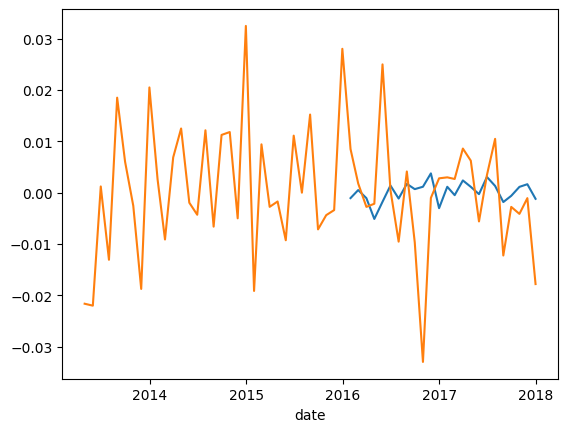

In [7]:
sns.lineplot(y=y_forecast[:, 4], x=yields.index)
sns.lineplot(y=y_all[:, 4][500:], x=yields[500:].index)

# Test in-sample fit

In [8]:
# full-sample R2 for comparison
y = xr['36'].values
model = HistoricalMeanModel()
model.fit(X, y)
r2_full = sklearn.metrics.r2_score(y, model.predict(X))
r2_full

NameError: name 'HistoricalMeanModel' is not defined

<Axes: xlabel='date'>

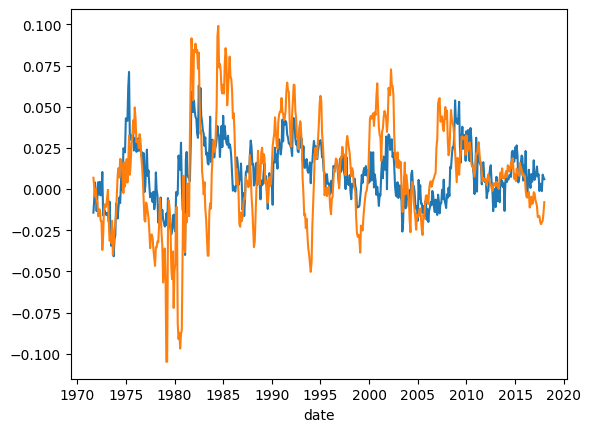

In [ ]:
sns.lineplot(y=model.predict(X), x=yields.index)
sns.lineplot(y=y, x=yields.index)